# PyTorch Computer Vision

## 0. Computer Vision libraries in Pytorch

* `torchvision` - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for copmuter vision
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with and ML model
* `torch.utils.data.Datset` - Base dataset class for PyTorch.
* `torch.utils.data.DataLoadser` - Creates a Python iterable over a dataset



In [ ]:
# import pytorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


## 1. Getting a datset

Data set we'll use: FashionMNIST

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",  # where to download the data to
    train=True,  # Do we want the training dataset (if False, we get the test set)
    download=True,  # Do we want to download it
    transform=ToTensor(),  # how do we want to transform the data
    target_transform=None  # how do we want to transform the labels/targets
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)


In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
# See the first training example
image, label = train_data[0]  # it's a tuple of the image tensor and its label
# image, label

In [ ]:
image.size()

torch.Size([1, 28, 28])

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [ ]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


### 1.2 Visualizing our data

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

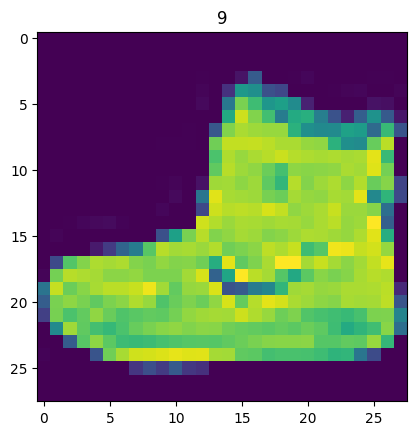

In [ ]:
import matplotlib.pyplot as plt

image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image[0, :, :])  # or `plt.imshow(image.squeeze())`
plt.title(label)

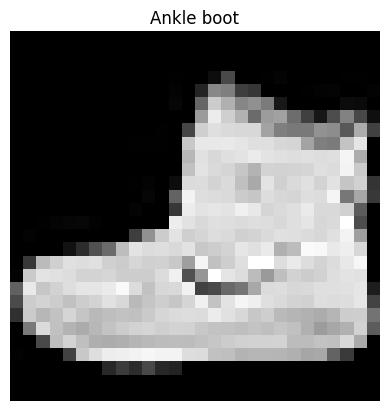

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);
plt.axis(False);

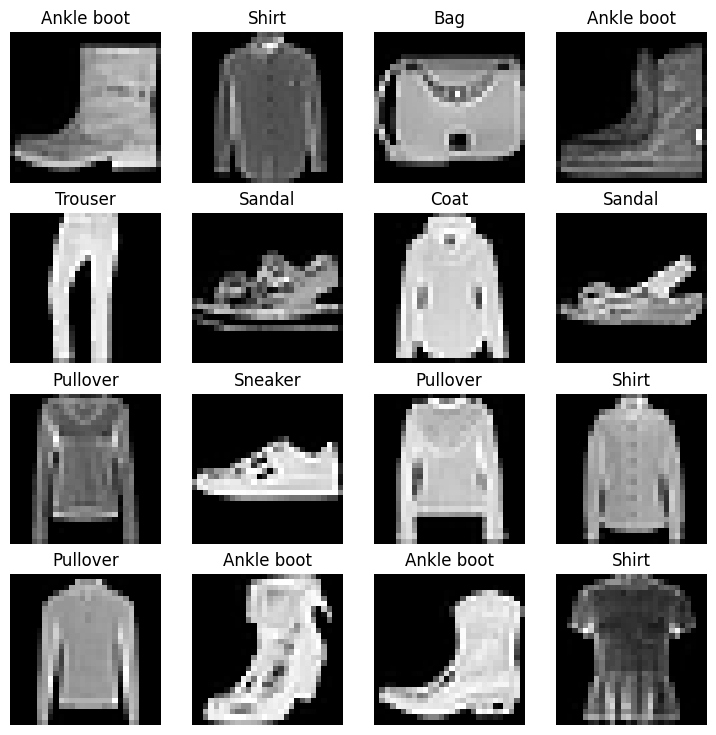

In [ ]:
# plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## 2. Prepare DataLoader

Right now our data is in the form of PyTorch datasets.

DataLoader turns our dataset into a python iterable.

More specifically, we want to turn our data into batches.

Why?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60,000 images in one go. So we break it down to 32 images at a time (batch size of 32).
2. It gives our neural network more chances to update its gradients per epoch.

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)  # Consider whether you want to shuffle, since order may matter when learning

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)  # order of test set doesn't matter, because no learning is occurring here

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f44e8d2fee0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f44e8d2c310>)

In [ ]:
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f44e8d2fee0>, <torch.utils.data.dataloader.DataLoader object at 0x7f44e8d2c310>)
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


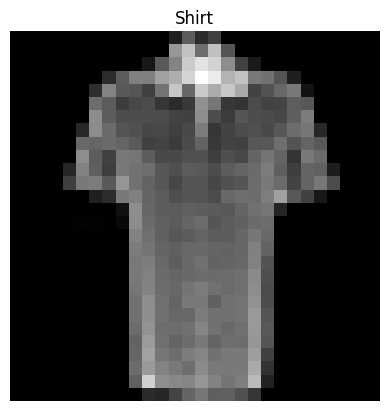

In [ ]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx],train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a baseline model

when starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [ ]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# flatten the sample
output = flatten_model(x)

# print what happened
print(f"Shape before flattening: {x.shape}")  # -> [color channels, height, width]
print(f"Shape after flattening: {output.shape}")  # -> [color_channels, height*width]

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [ ]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)


In [ ]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784,  # 28*28
    hidden_units=10,  # units in hidden layer
    output_shape=len(class_names)
)
model_0.to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [ ]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 Setup loss, optimizer, and eval metrics

* loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - our optimizer `torch.optim.SGD()`
* Evaluation metric - since we're working a classification problem, let's use accuracy as our evaluation metric

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download...")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download...


In [ ]:
# import acc metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


### 3.2 Creating a function to time our experiments

Machine learning is very experiment-driven.

Two main things to track are:
1. Model's performance (loss and accuracy)
2. How fast it runs

In [ ]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
start_time = timer()
# some code
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


4.842800012738735e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calcualte the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate test loss *per batch*.
4. Print out what's going on.
5. Time it all

In [ ]:
# import tqdm for progress bar
from tqdm.auto import tqdm

# set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs
epochs = 3

# create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")

    ### Training
    train_loss = 0

    # Add a loop to loop through batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss  # accumulate total train loss per batch

        # 3. zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()


        # print out what's going on
        if batch % 300 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss = 0
    test_acc = 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1. Forward Pass
            test_pred = model_0(X_test)

            # 2. Calculate loss
            test_loss += loss_fn(test_pred, y_test)

            # 3. Calculate Accuracy
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        # Calculate the test loss avg. per batch
        test_loss /= len(test_dataloader)

        # Calculate the test acc average per batch
        test_acc /= len(test_dataloader)

    # Print it out
    print(f"\nTrain loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate the training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 9600/60000 samples.
Looked at 19200/60000 samples.
Looked at 28800/60000 samples.
Looked at 38400/60000 samples.
Looked at 48000/60000 samples.
Looked at 57600/60000 samples.

Train loss: 0.5904 | Test Loss: 0.5095, Test acc: 82.0387
Epoch: 1
------
Looked at 0/60000 samples.
Looked at 9600/60000 samples.
Looked at 19200/60000 samples.
Looked at 28800/60000 samples.
Looked at 38400/60000 samples.
Looked at 48000/60000 samples.
Looked at 57600/60000 samples.

Train loss: 0.4763 | Test Loss: 0.4799, Test acc: 83.1969
Epoch: 2
------
Looked at 0/60000 samples.
Looked at 9600/60000 samples.
Looked at 19200/60000 samples.
Looked at 28800/60000 samples.
Looked at 38400/60000 samples.
Looked at 48000/60000 samples.
Looked at 57600/60000 samples.

Train loss: 0.4550 | Test Loss: 0.4766, Test acc: 83.4265
Train time on cpu: 42.550 seconds


 ## 4. Make predictions and get Model 0 results


In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(next(model.parameters()).device), y.to(next(model.parameters()).device)
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)

            acc += accuracy_fn(y_true=y,
                                    y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,  # only works when model was created with a class name (so be sure to do this)
        "model_loss": loss.item(),
        "model_acc": acc
    }

model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic-code

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: Building a better model with non-linearity

We learned about the power of non-linearity in notebook 2

In [ ]:
from torch import nn

class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        # self.linear_layer_1 = nn.Linear(in_features=input_shape,
        #                                 out_features=hidden_units)
        # self.linear_layer_2 = nn.Linear(in_features=hidden_units,
        #                                 out_features=output_shape)

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)


In [ ]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.1 Setup loss, optimizer, and evaluation metrics

In [ ]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                         lr=0.1)

### 6.2 Functionaizing training and evaluation/testing loops

Let's create a function for:
* training loop - `train_step()`
* testing loop - `test_step()`

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs training steps with model trying to learn on data_loader."""

    ### Training
    model.train()
    train_loss, train_acc = 0, 0

    # Add a loop to loop through batches
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss and acc (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss  # accumulate total train loss per batch

        acc = accuracy_fn(y_true=y,
                          y_pred=y_pred.argmax(dim=1))
        train_acc += acc

        # 3. zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # print out what's going on
        # if batch % 400 == 0:
        #     print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples.")

    # Divide total train loss by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """Performs a testing-loop step on model going over data_loader"""

    ### Testing
    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            # 1. Forward Pass
            test_pred = model(X_test)

            # 2. Calculate loss
            test_loss += loss_fn(test_pred, y_test)

            # 3. Calculate Accuracy
            test_acc += accuracy_fn(y_true=y_test,
                                    y_pred=test_pred.argmax(dim=1))

        # Calculate the test loss avg. per batch
        test_loss /= len(data_loader)

        # Calculate the test acc average per batch
        test_acc /= len(data_loader)

        # Print it out
        print(f"Test Loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

In [ ]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)
train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")

    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)

    test_step(model=model_1,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=str(next(model_1.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 1.09199 | Train acc: 61.34%
Test Loss: 0.95636 | Test acc: 65.00%
Epoch: 1
------
Train loss: 0.78101 | Train acc: 71.93%
Test Loss: 0.72227 | Test acc: 73.91%
Epoch: 2
------
Train loss: 0.67027 | Train acc: 75.94%
Test Loss: 0.68500 | Test acc: 75.02%
Train time on cuda:0: 44.636 seconds


**Note:** Sometimes, depending on your data/hardware you might find that your model trains faster on CPU than GPU

Why is this?

1. It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU
2. The hardware you're using has a better CPU in terms of compute capability than the GPU

For more on how to make models compute faster, see here: https://horace.io/brrr_intro.html

In [ ]:
# Get model_1 results dict
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [ ]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 7. Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also known as ConvNets.

CNN's are known for their capabilities to find patterns in visual data.

To find out what's happening inside a CNN, see this website: https://poloclub.github.io/cnn-explainer


In [ ]:
# Create a convolutional neural network

class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates the TinyVGG model from CNN explainer website
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            # create our conv layer
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        # print(f"Output shape of classifier: {x.shape}")
        return x

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

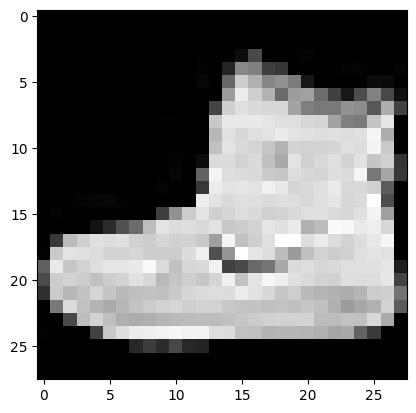

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")

In [ ]:
rand_image_tensor = torch.randn(size=(1, 28, 28)).to(device)
model_2.eval()
model_2(rand_image_tensor.unsqueeze(0))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 7.1 Stepping through `nn.Conv2d`

In [ ]:
torch.manual_seed(42)

# create a batch of images
images = torch.randn(size=(32, 1, 64 , 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 1, 64, 64])
Single image shape: torch.Size([1, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]]])


In [ ]:
# Create a single conv2d layer
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=1,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)
# play around with ^these values and see how the shape changes

# Pass the data throguh the convolutional layer
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

### 7.2 Stepping through `nn.MaxPool2d()`

In [ ]:
# Print out original image shape without unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")

# create a sample nn.MaxPool2d Layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv layer
test_image_through_conv = conv_layer(test_image)
print(f"shape after going through conv_layer: {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool: {test_image_through_max_pool.shape}")

Test image original shape: torch.Size([1, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 1, 64, 64])
shape after going through conv_layer: torch.Size([10, 62, 62])
Shape after going through conv_layer() and max_pool: torch.Size([10, 31, 31])


### 7.3 Setup a loss function and optimizer for `model_2`

In [ ]:
# Setup loss function / eval metrics / optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr = 0.1)

In [ ]:
# model_2.state_dict()

### 7.4 Training and testing `model_2` using our training and test functions

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_time_cnn_start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")

    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)

    test_step(model=model_2,
               data_loader=test_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

train_time_cnn_end = timer()
total_train_time_model_2 = print_train_time(start=train_time_cnn_start,
                                            end=train_time_cnn_end,
                                            device=str(next(model_2.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.59600 | Train acc: 78.40%
Test Loss: 0.40542 | Test acc: 85.70%
Epoch: 1
------
Train loss: 0.36309 | Train acc: 86.82%
Test Loss: 0.35997 | Test acc: 86.71%
Epoch: 2
------
Train loss: 0.32600 | Train acc: 88.18%
Test Loss: 0.33234 | Test acc: 87.76%
Train time on cuda:0: 44.061 seconds


In [ ]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33233919739723206,
 'model_acc': 87.75958466453675}

## 8. Compare model results and training time


In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.332339,87.759585


In [ ]:
# Add training time to results comparison dataframe
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,42.550045
1,FashionMNISTModelV1,0.685001,75.019968,44.635915
2,FashionMNISTModelV2,0.332339,87.759585,44.060597


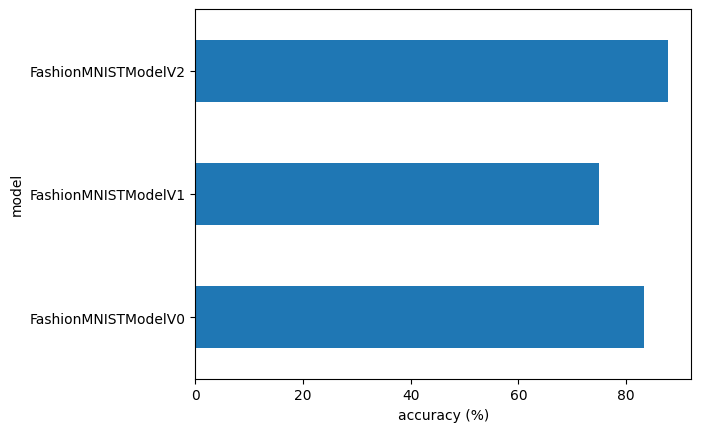

In [ ]:
# visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

## 9. Make and evaluate random predictions with best model

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # prepare the sample (add a batch dimensions and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)

            # Get prediction probs (logit -> probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred probs to turn list into a tensor
    return torch.stack(pred_probs)


In [ ]:
import random
# random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# view the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sneaker')

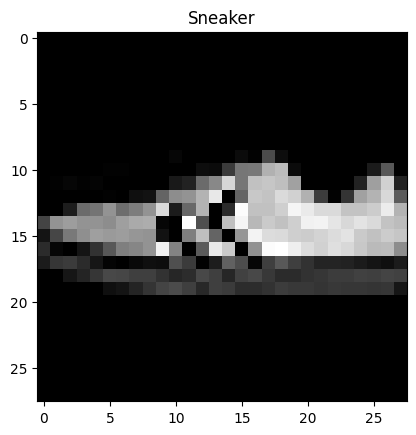

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [ ]:
# make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View the first two pred probs
pred_probs[:2]

tensor([[8.5284e-07, 1.3938e-06, 1.4878e-06, 2.1405e-06, 1.6687e-06, 8.3700e-04,
         1.1202e-07, 9.9895e-01, 1.9384e-04, 1.2523e-05],
        [8.8281e-04, 1.3461e-04, 1.1787e-03, 7.1674e-04, 9.9057e-01, 1.3434e-06,
         6.2250e-03, 2.0779e-06, 2.8983e-04, 1.1766e-06]])

In [ ]:
# convert pred probs to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([7, 4, 9, 7, 1, 7, 9, 4, 2])

(-0.5, 27.5, 27.5, -0.5)

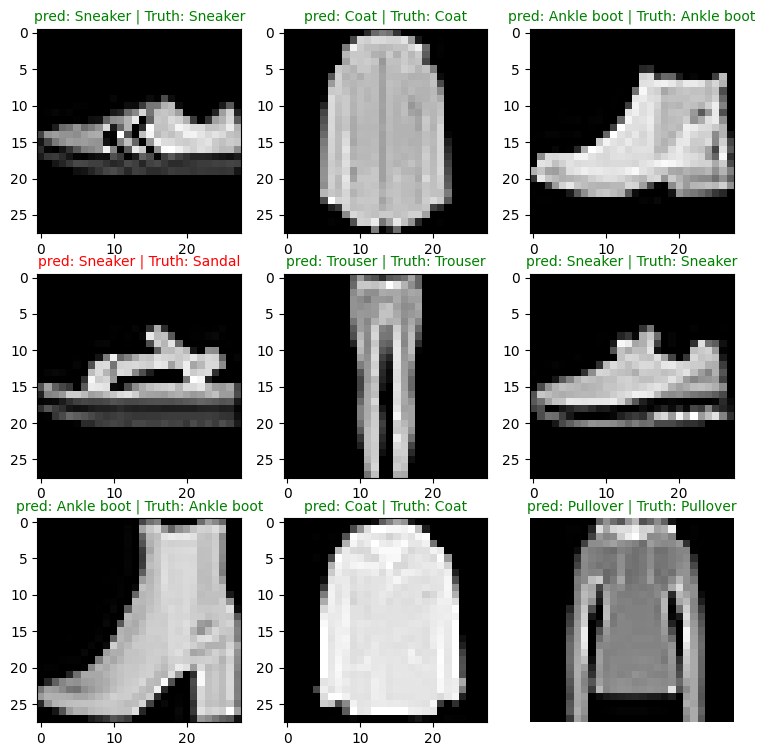

In [ ]:
# plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # create sublplot for each sample
    plt.subplot(nrows, ncols, i+1)

    # plot target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # find the prediction (in text form, not index)
    pred_label = class_names[pred_classes[i]]

    # Get truth label (in text, not index)
    truth_label = class_names[test_labels[i]]

    # Create a titlefor the plot
    title_text = f"pred: {pred_label} | Truth: {truth_label}"

    # check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")

plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation

A confusion matrix is a fantastic way of evaluating your classification models visually

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix`
https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`
https://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/

In [ ]:
from tqdm.auto import tqdm

# 1. make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)

        y_logit = model_2(X)

        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

        y_preds.append(y_pred.cpu())

    # print(y_preds)
    y_pred_tensor = torch.cat(y_preds)

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
len(y_pred_tensor)

10000

In [ ]:
try:
    import torchmetrics, mlxtend
    print(mlxtend.__version__)
    assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(mlxtend.__version__)

0.22.0
0.22.0


In [ ]:
import mlxtend
print(mlxtend.__version__)

0.22.0


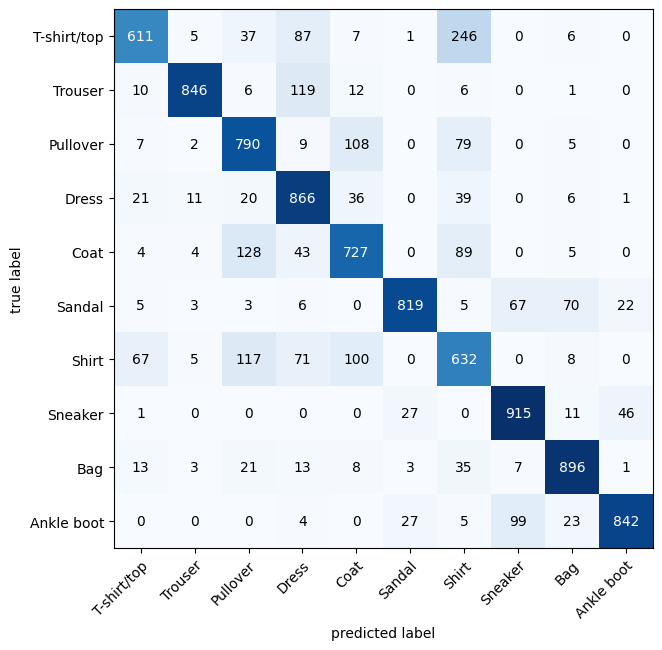

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names),
                          task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

## 11. Save and load our CNN

In [ ]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# create model save path
MODEL_NAME = "03_pytorch_copmuter_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

saving model to: models/03_pytorch_copmuter_vision_model_2.pth


In [ ]:
# Create a new instance to load model into
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=10)

# load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# send the model to the target device
loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33233919739723206,
 'model_acc': 87.75958466453675}

In [ ]:
# evaluate loaded model (expect similar results)
torch.manual_seed(42)
loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33233919739723206,
 'model_acc': 87.75958466453675}

In [ ]:
# Check if model results are close
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08  # absolute tolerance; adjust to allow for wider differences than the default
              )

tensor(True)